


### **Few-Shot Keyword Spotting,
** from _Interspeech 2021 [`[paper]`](https://isca-speech.org/archive/pdfs/interspeech_2021/mazumder21_interspeech.pdf) 


a few-shot transfer learning method for keyword spotting
 - Leveraging open speech corpora in nine languages, automates the extraction of a large multilingual keyword bank and use it to train an embedding model. 
 - With just 5 training examples, it fine-tunes the embedding model for keyword spotting and achieve an average F1 score of 0.75 on keyword classification for 180 new keywords unseen by the embedding model in these nine languages. 
 - This embedding model also generalizes to new languages. 
 - It achieves an average F1 score of 0.65 on 5-shot models for 260 keywords sampled across 13 new languages unseen by the embedding model. 
- Streaming accuracy investigates for our 5-shot models in two contexts: 
        
        - keyword spotting and keyword search. 
        - Across 440 keywords in 22 languages, an average streaming keyword spotting accuracy of 87.4% with a false acceptance rate of 4.3%, achieved and observed promising initial results on keyword search.

using MSWC dataset as unseen dataset and then use it to train a few-shot keyword-spotting model with the unseen dataset.



=========================================
#### 3 Datasets and one pre-trained model

__4 assets used (3 datasets and one pretrained model):__

1. Google Speech Commands (GSC) , a reference-quality keyword spotting dataset in English. 

     - TODO: Using the background noise samples in GSC for finetuning the model.
2. The MSWC *microset:*
> This is a small portion (a "microset") of the data available for the English and Spanish languages in the Multilingual Spoken Words Corpus (MSWC), limited to 6000 clips per keyword, and constrained to only 31 keywords in English and 20 keywords in Spanish. The intent of this small subset is to aid in preliminary experimentation, inspection, and tutorials, without requiring users to download the full MSWC dataset or the full subset of MSWC in English or Spanish.
3. A multilingual embedding model, which is a pretrained keyword feature extractor which can be used __to perform few-shot keyword spotting (FS-KWS)__ (see the paper for additional details). 
     - TODO: finetune this pretrained model for FS-KWS
4. An unknown-keyword dataset: a precomputed bank of unknown keywords to preserve the ability for a few-shot model to distinguish between the target keyword and non-target keywords (see the paper for additional details). 

    - TODO: use samples from this bank to finetune the keyword spotting model.

#### Import Modules, download data, and model


In [1]:
!git clone https://github.com/harvard-edge/multilingual_kws/
import sys
sys.path.append("/content/multilingual_kws/")

from multilingual_kws.embedding import transfer_learning, input_data

import tensorflow as tf
import numpy as np
import IPython
from pathlib import Path
import matplotlib.pyplot as plt
import os
import subprocess
import csv
from tqdm.notebook import tqdm

Cloning into 'multilingual_kws'...
remote: Enumerating objects: 1220, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 1220 (delta 106), reused 91 (delta 85), pack-reused 1087
Receiving objects: 100% (1220/1220), 19.77 MiB | 19.86 MiB/s, done.
Resolving deltas: 100% (778/778), done.


In [2]:
assets = [
  ("http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz", "/content/speech_commands")
, ("https://storage.googleapis.com/public-datasets-mswc/mswc_microset.tar.gz", "/content/mswc_microset")
, ("https://github.com/harvard-edge/multilingual_kws/releases/download/v0.1-alpha/multilingual_context_73_0.8011.tar.gz", "/content/embedding_model")
, ("https://github.com/harvard-edge/multilingual_kws/releases/download/v0.1-alpha/unknown_files.tar.gz", "/content/unknown_files")
]
for asset,cache in assets:
    tf.keras.utils.get_file(origin=asset, untar=True, cache_subdir=cache)

51730843/51730843 [==============================] - 0s 0us/step


In [4]:
# `opus-tools` package to convert the 48KHz `.opus` files in MSWC to 16KHz `.wav` files.
!apt-get -qq install opus-tools sox

In [5]:
# __Note:__
# for now: convert 20 random samples of each keyword since converting everything can take a while. 
# TODO: change `CONVERT_ALL` to `True`

CONVERT_ALL = False
N_SAMPLES_TO_CONVERT = 20

src = Path("./mswc_microset/mswc_microset/")
dest = Path("./mswc_microset")
rng = np.random.RandomState(0) # we also sort FS listings to aid reproducibility

for language in ["en", "es"]:
    pbar = tqdm(sorted(os.listdir(src / language / "clips"))) # for viewing progress
    for word in pbar:
        pbar.set_description(f"Converting {language}/{word}")
        destdir = dest / language / "clips" / word
        destdir.mkdir(parents=True, exist_ok=True)
        samples = list((src / language / "clips" / word).glob("*.opus"))
        samples.sort()
        if not CONVERT_ALL and len(samples) > N_SAMPLES_TO_CONVERT: 
            samples = rng.choice(samples, N_SAMPLES_TO_CONVERT, replace=False)
        for o in tqdm(samples, leave=False):
            dest_file = destdir / (o.stem + ".wav")
            cmd = ["opusdec", "--rate", "16000", o, dest_file]
            subprocess.run(cmd)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
"""Listening to 3 examples of the word "three":
* An example in English from GSC 
* An example in English from the MSWC_EN microset
* An example in Spanish ("tres") from the MSWC_ES microset"""

three_gsc = list(sorted(Path("./speech_commands/three").glob("*.wav")))
three_mswc_en = list(sorted(Path("./mswc_microset/en/clips/three").glob("*.wav")))
three_mswc_es = list(sorted(Path("./mswc_microset/es/clips/tres").glob("*.wav")))

def listen(filepath):
    IPython.display.display(IPython.display.Audio(filename=filepath, rate="16000"))

print("GSC")
listen(three_gsc[0])
print("MSWC EN")
listen(three_mswc_en[0])
print("MSWC ES")
listen(three_mswc_es[0])

GSC


MSWC EN


MSWC ES


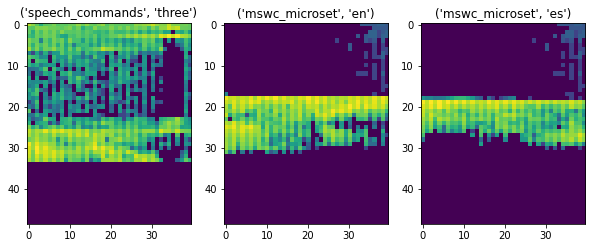

In [7]:
# using using TensorFlow Lite Micro's speech preprocessing frontend for spectrograms
settings = input_data.standard_microspeech_model_settings(label_count=1)
fig,axes = plt.subplots(ncols=3)
for sample, ax in zip([three_gsc[0], three_mswc_en[0], three_mswc_es[0]], axes):
    spectrogram = input_data.file2spec(settings, str(sample)) # PosixPath not supported
    ax.imshow(spectrogram.numpy())
    ax.set_title(sample.parts[:2])
fig.set_size_inches(10,5)

In [8]:
# all files should have 16KHz smapling freq. and exactly 1 second long
print(subprocess.check_output(["soxi", three_mswc_es[0]]).decode("utf8"))


Input File     : 'mswc_microset/es/clips/tres/common_voice_es_18797437.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.00 = 16000 samples ~ 75 CDDA sectors
File Size      : 32.0k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM




#### Train a Keyword Spotting Model


In [16]:
# create an embedding model:  from the pretrained classification model, removing the last layer of the classifier.
# ignoring tensorflow warnings

base_model = tf.keras.models.load_model("./embedding_model/multilingual_context_73_0.8011")
embedding = tf.keras.models.Model(
    name="embedding_model",
    inputs=base_model.inputs,
    outputs=base_model.get_layer(name="dense_2").output,
)
embedding.trainable = False

Filepath: mswc_microset/en/clips/three/common_voice_en_15680.wav
Spectrogram shape (49, 40)
1/1 [==============================] - 2s 2s/step
Feature vector shape: (1, 1024)


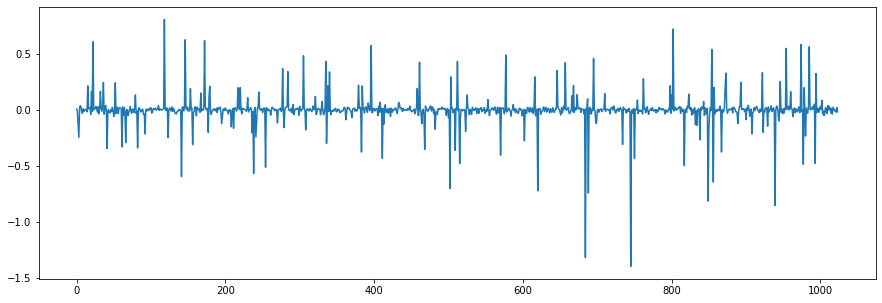

In [12]:
# embedding representation for one of our samples above:

sample_fpath = str(three_mswc_en[0])
print("Filepath:", sample_fpath)
spectrogram = input_data.file2spec(settings, sample_fpath)
print("Spectrogram shape", spectrogram.shape)
# retrieve embedding vector representation (reshape into 1x49x40x1)
feature_vec = embedding.predict(spectrogram[tf.newaxis, :, :, tf.newaxis])
print("Feature vector shape:", feature_vec.shape)
plt.plot(feature_vec[0]);
plt.gcf().set_size_inches(15,5)


#### Embedding Visualization


20/20 [==============================] - 3s 82ms/step


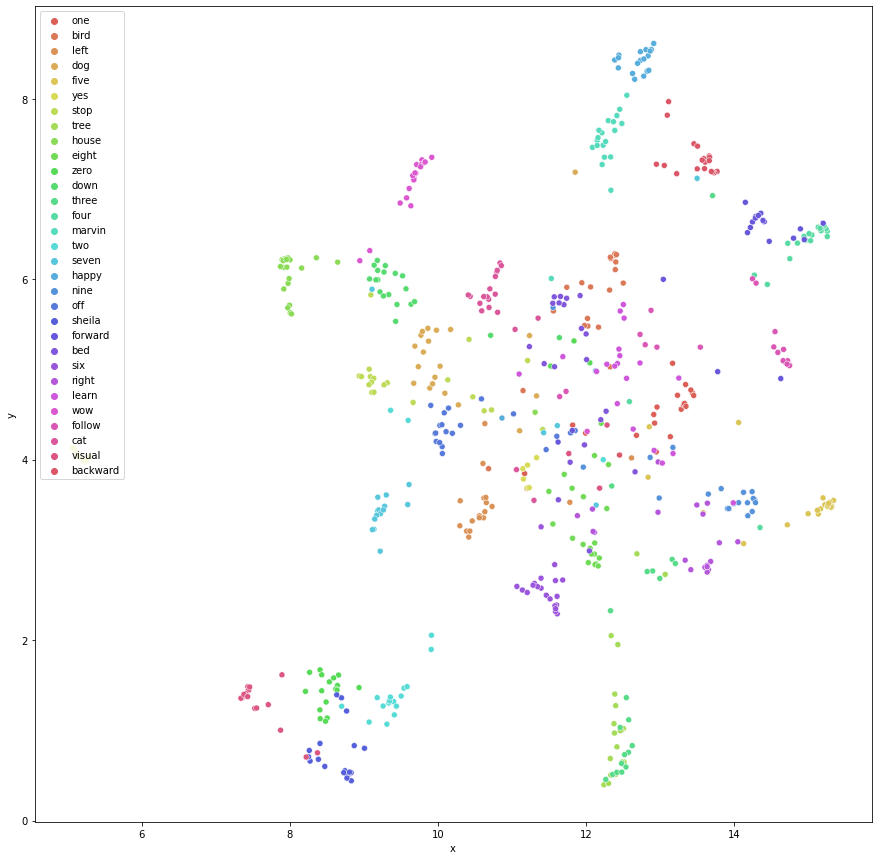

In [17]:
# 2D projection of the embedding representation. to visualize keyword clusters:
!pip install -q umap-learn
import umap
import pandas as pd
import sklearn.preprocessing
import seaborn as sns
reducer = umap.UMAP()
wavs = list(Path("mswc_microset/en/clips").rglob("*.wav"))
labels = [w.parts[-2] for w in wavs]
spectrograms = np.array([input_data.file2spec(settings, str(w)) for w in wavs])
embeddings = embedding.predict(spectrograms)
scaled_embeddings = sklearn.preprocessing.StandardScaler().fit_transform(embeddings)
projection = reducer.fit_transform(scaled_embeddings)
df = pd.DataFrame(data=dict(x=projection[:,0], y=projection[:, 1], keyword=labels))
kws = set(df.keyword.tolist())
sns.scatterplot(x="x", y="y", hue=df.keyword.tolist(), data=df, palette=sns.color_palette("hls", n_colors=len(kws)))
plt.gcf().set_size_inches(15,15)

In [18]:
"""
Training a 5-shot model to classify the Spanish keyword "tiempo" (which can mean "time" or "weather" in English). 
* converting the remaining samples into `.wav` files.
* selecting 5 training examples from the training split.
* finetuning our embedding model on these 5 examples.
* compute accuracy on the test split, and against a selection of non-target words from MSWC and GSC

"""
# Converting all microset samples of our selected keyword
LANG="es" # ISOCODE for spanish
KEYWORD="tiempo" 
src_files = list(Path(f"mswc_microset/mswc_microset/{LANG}/clips/{KEYWORD}").glob("*.opus"))
dest_dir = Path(f"mswc_microset/{LANG}/clips/{KEYWORD}")
for sample in tqdm(src_files):
    dest_file = dest_dir / (sample.stem + ".wav")
    cmd = ["opusdec", "--rate", "16000", sample, dest_file]
    subprocess.run(cmd)

  0%|          | 0/1520 [00:00<?, ?it/s]

In [19]:
# load the training and test splits
splits = {}
with open("mswc_microset/mswc_microset/es/es_splits.csv", "r") as fh:
    reader = csv.reader(fh)
    next(reader) # skip header: SET,LINK,WORD,VALID,SPEAKER,GENDER
    for row in reader:
        if row[2] == KEYWORD:
            wav = Path(row[1]).stem + ".wav"
            splits[wav] = row[0].lower()

all_samples = [str(s) for s in sorted(Path(f"mswc_microset/{LANG}/clips/{KEYWORD}").glob("*.wav"))]
print("# of total samples", len(all_samples))
train_samples = [s for s in all_samples if splits[Path(s).name] == "train"]
print("# of train samples", len(train_samples))
dev_samples = [s for s in all_samples if splits[Path(s).name] == "dev"]
print("# of dev samples", len(dev_samples))
test_samples = [s for s in all_samples if splits[Path(s).name] == "test"]
print("# of test samples", len(test_samples))

# of total samples 1520
# of train samples 1216
# of dev samples 152
# of test samples 152


In [20]:
# for listening assessment (5 examples from training split):

rng = np.random.RandomState(0)
five_samples = rng.choice(train_samples, 5, replace=False).tolist()
print(five_samples)
for s in five_samples:
    listen(s)

['mswc_microset/es/clips/tiempo/common_voice_es_20909110.wav', 'mswc_microset/es/clips/tiempo/common_voice_es_18312321.wav', 'mswc_microset/es/clips/tiempo/common_voice_es_20343100.wav', 'mswc_microset/es/clips/tiempo/common_voice_es_20379087.wav', 'mswc_microset/es/clips/tiempo/common_voice_es_19955827.wav']


In [21]:
#training the few-shot model:
# a) it needs a set of unknown keywords
# b) background noise samples from Google Speech Commands. 
#ignoring any emitted warnings when loading the pretrained classifier.

background_noise = "/content/speech_commands/_background_noise_/"
unknown_files_txt = "/content/unknown_files/unknown_files.txt"
unknown_files=[]
with open(unknown_files_txt, "r") as fh:
    for w in fh.read().splitlines():
        unknown_files.append("/content/unknown_files/" + w)
print("Number of unknown files", len(unknown_files))

print("---Training model---")
model_settings = input_data.standard_microspeech_model_settings(3)
_, model, _ = transfer_learning.transfer_learn(
    target=KEYWORD,
    train_files=five_samples,
    val_files=dev_samples,
    unknown_files=unknown_files,
    num_epochs=4,
    num_batches=1,
    batch_size=64,
    primary_lr=0.001,
    backprop_into_embedding=False,
    embedding_lr=0,
    model_settings=model_settings,
    base_model_path="embedding_model/multilingual_context_73_0.8011",
    base_model_output="dense_2",
    UNKNOWN_PERCENTAGE=50.0,
    bg_datadir=background_noise,
    csvlog_dest=None,
)
model.save(f"{KEYWORD}_5shot")


Number of unknown files 4970
---Training model---


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/4
64/64 [==============================] - 24s 278ms/step - loss: 0.4457 - accuracy: 0.8569 - val_loss: 0.2241 - val_accuracy: 0.9408
Epoch 2/4
64/64 [==============================] - 18s 289ms/step - loss: 0.1481 - accuracy: 0.9802 - val_loss: 0.2619 - val_accuracy: 0.8882
Epoch 3/4
64/64 [==============================] - 16s 255ms/step - loss: 0.0735 - accuracy: 0.9883 - val_loss: 0.3283 - val_accuracy: 0.8487
Epoch 4/4
64/64 [==============================] - 16s 258ms/step - loss: 0.0465 - accuracy: 0.9929 - val_loss: 0.3941 - val_accuracy: 0.8421


INFO:tensorflow:Assets written to: tiempo_5shot/assets


In [22]:
# with only 5 exmaples for above word, we can achieve about 90% accuracy in classification. 
test_spectrograms = np.array([input_data.file2spec(settings, f) for f in test_samples])
# fetch softmax predictions from the finetuned model:
# (class 0: silence/background noise, class 1: unknown keyword, class 2: target)
predictions = model.predict(test_spectrograms)
categorical_predictions = np.argmax(predictions, axis=1)
# which predictions match the target class? 
accuracy = categorical_predictions[categorical_predictions == 2].shape[0] / predictions.shape[0]
print(f"Test accuracy on testset: {accuracy:0.2f}")

5/5 [==============================] - 2s 86ms/step
Test accuracy on testset: 0.89


In [23]:
# listening to five random correctly-classified examples from the test set:
sample_idxs = np.random.choice(np.flatnonzero(categorical_predictions == 2), 5, replace=False)
for i in sample_idxs:
    listen(test_samples[i])

In [24]:
# and 5 incorrectly-classified examples. These may be a mix of 
# false negatives (true instances of the keyword which were classified incorrectly) and 
# anomalous samples (due to errors in forced alignment or the original crowdsourced data).
sample_idxs = np.random.choice(np.flatnonzero(categorical_predictions != 2), 5, replace=False)
for i in sample_idxs:
    listen(test_samples[i])

In [25]:
# verifying the keyword spotting model correctly categorizes non-target words as "unknown" by
# selecting the 20 random `.wav` files we converted for each of the remaining subset of keywords in our Spanish microset (in total, 380 samples),
# and running predictions on their spectrograms. We should observe around 95% of these words are correctly classified as `"unknown"` by our 5-shot model.
non_target_examples = []
for word in os.listdir(f"mswc_microset/{LANG}/clips"):
    if word == KEYWORD:
        continue
    non_target_examples.extend(Path(f"mswc_microset/{LANG}/clips/{word}").glob("*.wav"))
print("Number of non-target examples", len(non_target_examples))

non_target_spectrograms = np.array([input_data.file2spec(settings, str(f)) for f in non_target_examples])
# fetch softmax predictions from the finetuned model:
# (class 0: silence/background noise, class 1: unknown keyword, class 2: target)
predictions = model.predict(non_target_spectrograms)
categorical_predictions = np.argmax(predictions, axis=1)
# which predictions match the non-target class? 
accuracy = categorical_predictions[categorical_predictions == 1].shape[0] / predictions.shape[0]
print(f"Estimated accuracy on non-target samples: {accuracy:0.2f}")

Number of non-target examples 380
12/12 [==============================] - 1s 122ms/step
Estimated accuracy on non-target samples: 0.96


### Report and Observation:
the accuracy of a few-shot model can be quite sensitive to the particular samples chosen. A different set of five training samples will likely vary by a few percentage points from this model. The subset of unknown words and background noise also impact accuracy. Furthermore, some of the extracted test samples may be truncated (due to incorrect word boundary estimates) or occasionally anomalous due to issues with the originating crowdsourced data so a more accurate estimate of the test performance can only be made after manually listening to all test samples and discarding any malformed samples.

### Next step: 
 - Try custom key word spotting like "hey computer"
 - Having an interface for few shot leanring (training), evaluation, and inference for visualization interactively on continious audio.
